<a href="https://colab.research.google.com/github/joaopamaral/pytorch_challenge/blob/master/Image%20Classifier%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/joaopamaral/pytorch_challenge/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Download Pytorch - Google Colab - http://pytorch.org/
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
    pytorch_version = '0.4.1'
    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-{pytorch_version}-{platform}-linux_x86_64.whl torchvision
        
    import PIL
    # Check PIL Version (Bug Google Colab)
    print('PIL.PILLOW_VERSION', PIL.PILLOW_VERSION)
    # workaround 
    if PIL.PILLOW_VERSION != '5.3.0':
        !pip install Pillow==5.3.0
        print('Restart Runtime before run the notebook!')

# Imports here
%matplotlib inline
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models, datasets
import tqdm

torch.cuda.manual_seed(0)

PIL.PILLOW_VERSION 5.3.0


In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')

CUDA is available!


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
# download the dataset
!wget -q -nc https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!wget -q -nc https://raw.githubusercontent.com/joaopamaral/pytorch_challenge/master/cat_to_name.json
!unzip -q -o flower_data.zip

In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train/'
valid_dir = data_dir + '/valid/'

In [0]:
mean = np.array((0.485, 0.456, 0.406))
std = np.array((0.229, 0.224, 0.225))

# TODO: Define your transforms for the training and validation sets
training_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.RandomResizedCrop(224), 
                                         transforms.RandomRotation(90),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean, std)])

validation_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean, std)])

# TODO: Load the datasets with ImageFolder
train_datasets = datasets.ImageFolder(train_dir, transform=training_transform)
validation_datasets = datasets.ImageFolder(valid_dir, transform=validation_transform)

# TODO: Using the image datasets and the trainforms, define the dataloaders
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_datasets, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
print(cat_to_name['1'])

pink primrose


### Visualize some sample data

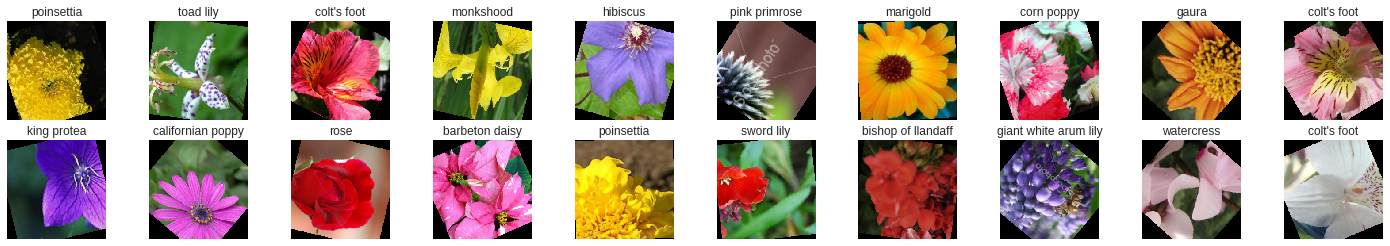

In [7]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    image = ((np.transpose(images[idx], (1, 2, 0)) * std) + mean).clip(min=0)
    plt.imshow(image)
    ax.set_title(cat_to_name[str(labels[idx].item())])

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
# TODO: Build and train your network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 500),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(500, 102),
                                 nn.LogSoftmax(dim=1))

model.to(device);
# print(model)

criterion = nn.CrossEntropyLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adagrad(model.fc.parameters(), lr=0.01)
# optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
# optimizer = optim.SGD(model.fc.parameters(), lr=0.001)

In [9]:
# number of epochs to train the model
n_epochs = 50

valid_loss_min = np.Inf # track change in validation loss
train_loss_per_epoch = []
valid_loss_per_epoch = []
valid_accuracy_per_epoch = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(tqdm.tqdm(train_loader, desc=f'Training Model, Epoch {epoch}')):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    correct_validation = 0.0
    total_analised = 0.0
    for batch_idx, (data, target) in enumerate(tqdm.tqdm(validation_loader, desc=f'Validating Model, Epoch {epoch}')):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate accuracy
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        correct_validation += correct.sum()
        total_analised += correct.size
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(validation_loader.dataset)
    accuaracy_validation = correct_validation / len(validation_loader.dataset)
    
    train_loss_per_epoch.append(train_loss)
    valid_loss_per_epoch.append(valid_loss)
    valid_accuracy_per_epoch.append(accuaracy_validation)
        
    # print training/validation statistics 
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \tAccuracy: {accuaracy_validation*100:.6f}%')
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Validating Model, Epoch 1: 100%|██████████| 9/9 [00:26<00:00,  2.48s/it]


Epoch: 1 	Training Loss: 4.759821 	Validation Loss: 3.349124 	Accuracy: 28.361858%
Validation loss decreased (inf --> 3.349124).  Saving model ...


Validating Model, Epoch 2: 100%|██████████| 9/9 [00:26<00:00,  2.48s/it]


Epoch: 2 	Training Loss: 2.947202 	Validation Loss: 2.400931 	Accuracy: 45.232274%
Validation loss decreased (3.349124 --> 2.400931).  Saving model ...


Validating Model, Epoch 3: 100%|██████████| 9/9 [00:26<00:00,  2.49s/it]


Epoch: 3 	Training Loss: 2.302429 	Validation Loss: 1.857780 	Accuracy: 59.290954%
Validation loss decreased (2.400931 --> 1.857780).  Saving model ...


Validating Model, Epoch 4: 100%|██████████| 9/9 [00:26<00:00,  2.48s/it]


Epoch: 4 	Training Loss: 1.955735 	Validation Loss: 1.619542 	Accuracy: 61.002445%
Validation loss decreased (1.857780 --> 1.619542).  Saving model ...


Validating Model, Epoch 5: 100%|██████████| 9/9 [00:26<00:00,  2.49s/it]


Epoch: 5 	Training Loss: 1.770594 	Validation Loss: 1.421761 	Accuracy: 68.092910%
Validation loss decreased (1.619542 --> 1.421761).  Saving model ...


Validating Model, Epoch 6: 100%|██████████| 9/9 [00:26<00:00,  2.48s/it]


Epoch: 6 	Training Loss: 1.616666 	Validation Loss: 1.365571 	Accuracy: 65.525672%
Validation loss decreased (1.421761 --> 1.365571).  Saving model ...


Validating Model, Epoch 7: 100%|██████████| 9/9 [00:26<00:00,  2.48s/it]


Epoch: 7 	Training Loss: 1.526750 	Validation Loss: 1.283815 	Accuracy: 70.048900%
Validation loss decreased (1.365571 --> 1.283815).  Saving model ...


Validating Model, Epoch 8: 100%|██████████| 9/9 [00:26<00:00,  2.47s/it]


Epoch: 8 	Training Loss: 1.456440 	Validation Loss: 1.153587 	Accuracy: 72.982885%
Validation loss decreased (1.283815 --> 1.153587).  Saving model ...


Validating Model, Epoch 9: 100%|██████████| 9/9 [00:26<00:00,  2.48s/it]


Epoch: 9 	Training Loss: 1.393545 	Validation Loss: 1.098306 	Accuracy: 72.616137%
Validation loss decreased (1.153587 --> 1.098306).  Saving model ...


Validating Model, Epoch 10: 100%|██████████| 9/9 [00:26<00:00,  2.47s/it]


Epoch: 10 	Training Loss: 1.328144 	Validation Loss: 1.093931 	Accuracy: 71.882641%
Validation loss decreased (1.098306 --> 1.093931).  Saving model ...


Validating Model, Epoch 11: 100%|██████████| 9/9 [00:26<00:00,  2.50s/it]


Epoch: 11 	Training Loss: 1.283658 	Validation Loss: 0.988758 	Accuracy: 74.327628%
Validation loss decreased (1.093931 --> 0.988758).  Saving model ...


Validating Model, Epoch 12: 100%|██████████| 9/9 [00:26<00:00,  2.49s/it]


Epoch: 12 	Training Loss: 1.244265 	Validation Loss: 0.976147 	Accuracy: 76.405868%
Validation loss decreased (0.988758 --> 0.976147).  Saving model ...


Validating Model, Epoch 13: 100%|██████████| 9/9 [00:26<00:00,  2.49s/it]


Epoch: 13 	Training Loss: 1.213221 	Validation Loss: 0.965776 	Accuracy: 76.528117%
Validation loss decreased (0.976147 --> 0.965776).  Saving model ...


Training Model, Epoch 15:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 1.203906 	Validation Loss: 0.972651 	Accuracy: 76.283619%


Validating Model, Epoch 15: 100%|██████████| 9/9 [00:26<00:00,  2.48s/it]


Epoch: 15 	Training Loss: 1.185191 	Validation Loss: 0.948269 	Accuracy: 76.528117%
Validation loss decreased (0.965776 --> 0.948269).  Saving model ...


Training Model, Epoch 17:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 1.145203 	Validation Loss: 0.954007 	Accuracy: 76.650367%


Validating Model, Epoch 17: 100%|██████████| 9/9 [00:26<00:00,  2.48s/it]


Epoch: 17 	Training Loss: 1.137972 	Validation Loss: 0.894690 	Accuracy: 77.139364%
Validation loss decreased (0.948269 --> 0.894690).  Saving model ...


Validating Model, Epoch 18: 100%|██████████| 9/9 [00:26<00:00,  2.48s/it]


Epoch: 18 	Training Loss: 1.119838 	Validation Loss: 0.821871 	Accuracy: 80.440098%
Validation loss decreased (0.894690 --> 0.821871).  Saving model ...


Training Model, Epoch 20:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 1.094887 	Validation Loss: 0.863010 	Accuracy: 77.139364%


Training Model, Epoch 21:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 1.069119 	Validation Loss: 0.869918 	Accuracy: 77.750611%


Training Model, Epoch 22:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 1.061174 	Validation Loss: 0.922968 	Accuracy: 76.039120%


Validating Model, Epoch 22: 100%|██████████| 9/9 [00:26<00:00,  2.48s/it]


Epoch: 22 	Training Loss: 1.069013 	Validation Loss: 0.794184 	Accuracy: 79.584352%
Validation loss decreased (0.821871 --> 0.794184).  Saving model ...


Training Model, Epoch 24:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 1.055648 	Validation Loss: 0.866524 	Accuracy: 78.850856%


Training Model, Epoch 25:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 1.032672 	Validation Loss: 0.890472 	Accuracy: 78.484108%


Training Model, Epoch 26:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 1.011912 	Validation Loss: 0.808193 	Accuracy: 80.073350%


Validating Model, Epoch 26: 100%|██████████| 9/9 [00:26<00:00,  2.48s/it]


Epoch: 26 	Training Loss: 1.040680 	Validation Loss: 0.756829 	Accuracy: 81.418093%
Validation loss decreased (0.794184 --> 0.756829).  Saving model ...


Validating Model, Epoch 27: 100%|██████████| 9/9 [00:26<00:00,  2.48s/it]


Epoch: 27 	Training Loss: 0.988256 	Validation Loss: 0.735908 	Accuracy: 80.929095%
Validation loss decreased (0.756829 --> 0.735908).  Saving model ...


Validating Model, Epoch 28: 100%|██████████| 9/9 [00:26<00:00,  2.47s/it]


Epoch: 28 	Training Loss: 0.984544 	Validation Loss: 0.735787 	Accuracy: 81.784841%
Validation loss decreased (0.735908 --> 0.735787).  Saving model ...


Training Model, Epoch 30:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.984635 	Validation Loss: 0.780872 	Accuracy: 81.173594%


Training Model, Epoch 31:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.980037 	Validation Loss: 0.782775 	Accuracy: 79.706601%


Training Model, Epoch 32:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 31 	Training Loss: 0.986113 	Validation Loss: 0.758137 	Accuracy: 80.562347%


Training Model, Epoch 33:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 32 	Training Loss: 0.944206 	Validation Loss: 0.741799 	Accuracy: 82.151589%


Training Model, Epoch 34:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 33 	Training Loss: 0.980235 	Validation Loss: 0.766950 	Accuracy: 80.806846%


Validating Model, Epoch 34: 100%|██████████| 9/9 [00:26<00:00,  2.48s/it]


Epoch: 34 	Training Loss: 0.931042 	Validation Loss: 0.699592 	Accuracy: 80.929095%
Validation loss decreased (0.735787 --> 0.699592).  Saving model ...


Training Model, Epoch 36:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 35 	Training Loss: 0.937102 	Validation Loss: 0.771204 	Accuracy: 79.462103%


Training Model, Epoch 37:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 36 	Training Loss: 0.949682 	Validation Loss: 0.750279 	Accuracy: 81.662592%


Training Model, Epoch 38:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 37 	Training Loss: 0.935831 	Validation Loss: 0.777096 	Accuracy: 81.295844%


Training Model, Epoch 39:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 38 	Training Loss: 0.928912 	Validation Loss: 0.716854 	Accuracy: 82.029340%


Training Model, Epoch 40:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 39 	Training Loss: 0.904688 	Validation Loss: 0.708433 	Accuracy: 81.173594%


Validating Model, Epoch 40: 100%|██████████| 9/9 [00:26<00:00,  2.48s/it]


Epoch: 40 	Training Loss: 0.914675 	Validation Loss: 0.692411 	Accuracy: 81.662592%
Validation loss decreased (0.699592 --> 0.692411).  Saving model ...


Training Model, Epoch 42:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 41 	Training Loss: 0.903509 	Validation Loss: 0.714336 	Accuracy: 81.662592%


Training Model, Epoch 43:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 42 	Training Loss: 0.906178 	Validation Loss: 0.704649 	Accuracy: 82.885086%


Validating Model, Epoch 43: 100%|██████████| 9/9 [00:26<00:00,  2.49s/it]


Epoch: 43 	Training Loss: 0.895451 	Validation Loss: 0.684110 	Accuracy: 82.518337%
Validation loss decreased (0.692411 --> 0.684110).  Saving model ...


Validating Model, Epoch 44: 100%|██████████| 9/9 [00:26<00:00,  2.49s/it]


Epoch: 44 	Training Loss: 0.890139 	Validation Loss: 0.680527 	Accuracy: 82.273839%
Validation loss decreased (0.684110 --> 0.680527).  Saving model ...


Validating Model, Epoch 45: 100%|██████████| 9/9 [00:26<00:00,  2.50s/it]


Epoch: 45 	Training Loss: 0.888960 	Validation Loss: 0.649055 	Accuracy: 84.352078%
Validation loss decreased (0.680527 --> 0.649055).  Saving model ...


Training Model, Epoch 47:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 46 	Training Loss: 0.887868 	Validation Loss: 0.661844 	Accuracy: 84.352078%


Validating Model, Epoch 47: 100%|██████████| 9/9 [00:26<00:00,  2.49s/it]


Epoch: 47 	Training Loss: 0.904901 	Validation Loss: 0.637024 	Accuracy: 82.885086%
Validation loss decreased (0.649055 --> 0.637024).  Saving model ...


Training Model, Epoch 49:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 48 	Training Loss: 0.869410 	Validation Loss: 0.678942 	Accuracy: 82.151589%


Training Model, Epoch 50:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch: 49 	Training Loss: 0.879380 	Validation Loss: 0.692583 	Accuracy: 82.029340%


Validating Model, Epoch 50: 100%|██████████| 9/9 [00:26<00:00,  2.49s/it]

Epoch: 50 	Training Loss: 0.886418 	Validation Loss: 0.666070 	Accuracy: 83.496333%


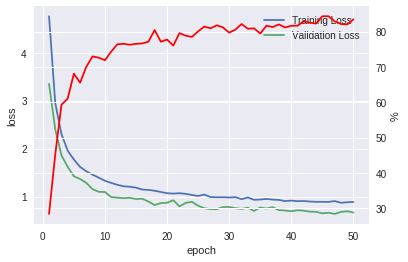

In [22]:
fig, ax1 = plt.subplots()
ax1.plot(range(1, n_epochs+1), train_loss_per_epoch);
ax1.plot(range(1, n_epochs+1), valid_loss_per_epoch);
plt.legend(['Training Loss', 'Validation Loss']);
plt.xlabel('epoch');
plt.ylabel('loss');

ax2 = ax1.twinx()
ax2.plot(range(1, n_epochs+1), np.asarray(valid_accuracy_per_epoch)*100, color='r');
plt.ylabel('%');

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# TODO: Save the checkpoint 

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='https://github.com/joaopamaral/pytorch_challenge/blob/master/assets/inference_example.png?raw=1' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# TODO: Display an image along with the top 5 classes